# Project Proposal — Heart Disease Prediction

## 1 - Introduction

Heart disease and its effective diagnosis is a global health challenge. In this proposal, we aim to address diagnosing heart diseases using machine learning techniques. We will attempt to detect the presence of heart disease in patients by leveraging a heart disease dataset obtained from Kaggle. The diagnosis (presence) ranges from 0 (no presence) to 4. However, our focus will be on distinguishing between the presence and absence of heart disease.

The original dataset consists of 16 variables, but we will focus on the following six variables.

1. **Id (id)** : patient Id 
2. **Age (age) **: Age of the patient.
3. **Resting Blood Pressure (trestbps)**: in mm Hg.
4. **Serum Cholesterol (chol)**: Serum cholesterol level in mg/dL.
5. **thalach (thalch)** : maximum heart rate  
6. **Heart Disease (presence)**: representing the degree of blockages or narrowing in major vessels.
   - P (present): < 50% diameter narrowing
   - N (non-present): > 50% diameter narrowing

We aim to answer the following question:

#### Can K-nearest neighbors (KNN) classification effectively diagnose heart disease using age, heart rate, blood pressure, and cholesterol levels?


## 2 - Preliminary exploratory data analysis

 ### 2.a. Data Cleaninng, wrangling and Table Summary

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [5]:

## We are using the heart disease data. As suggested by the professor we downloaded the csv file from kaggle and uploaded it into our notebook

file_path <- "data/heart_disease_uci.csv"

heart_disease_uci <- read_csv(file_path)

# selecting only the rows we need and Change 'num' to a factor
heart_disease_data <- heart_disease_uci |> 
         rename(presence = num) |>
         select(id, age, trestbps, chol, thalch, presence) |>
         mutate(presence = ifelse(presence == 0, "N", "P"),
                presence = as.factor(presence))
heart_disease_data
# Print the first few rows of the modified dataset
# head(heart_disease_data)

set.seed(3456)

# Split the heart disease data into training and testing sets 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = presence)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

# Table that reports the number of observations per variable (missing values removed)
observations_per_variable_tbl <- heart_disease_train |>
  summarize(across(age:thalch, ~ sum(!is.na(.)))) |>
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "number_of_observations")

# Table that reports the number of observations in presence (N vs P)
presence_observations_tbl <- heart_disease_train |>
    group_by(presence) |>
    summarize(count = sum(!is.na(presence)))


# table that reports the means of the predictor variable
mean_of_predictors_tbl <- heart_disease_train |>
  summarize(across(age:thalch, ~ mean(., na.rm = TRUE))) |>
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Mean")

# table that reports the number of rows with missing data
number_of_missing_values <- sum(rowSums(is.na(heart_disease_train)))

observations_per_variable_tbl
presence_observations_tbl
mean_of_predictors_tbl
number_of_missing_values

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,145,233,150,N
2,67,160,286,108,P
3,67,120,229,129,P
⋮,⋮,⋮,⋮,⋮,⋮
918,55,122,223,100,P
919,58,NA,385,NA,N
920,62,120,254,93,P


Variable,number_of_observations
<chr>,<int>
age,689
trestbps,641
chol,666
thalch,645


presence,count
<fct>,<int>
N,308
P,381


Variable,Mean
<chr>,<dbl>
age,53.5312
trestbps,131.9267
chol,197.5571
thalch,136.9380


[1] 115

#### 2.b. Visualization

Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


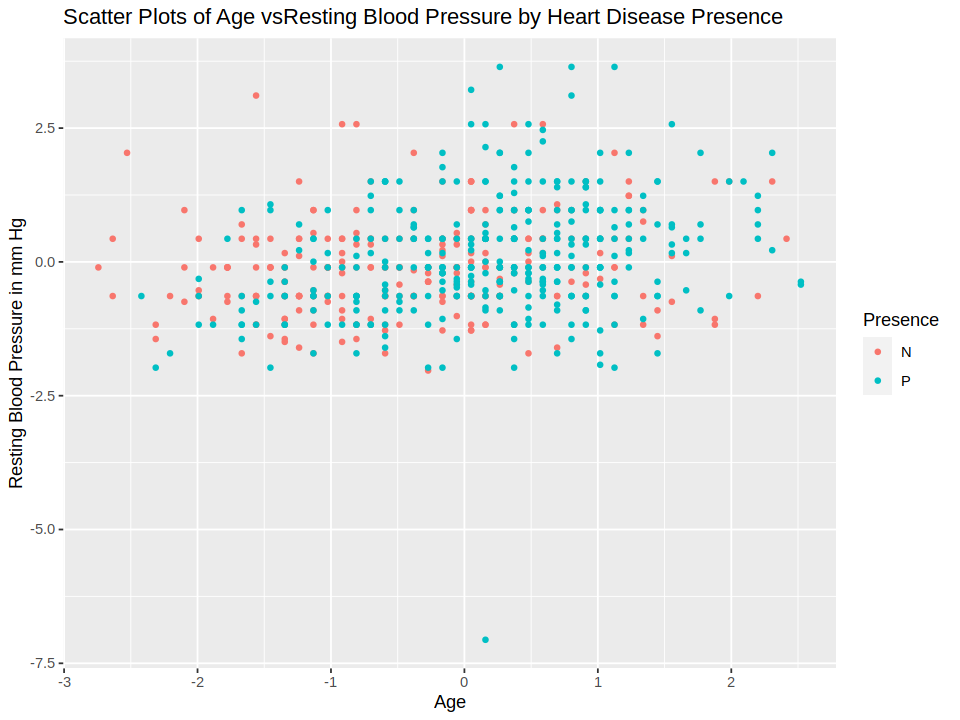

In [6]:


# standardizing the data
heart_disease_train_recipe  <- recipe(presence ~ age + trestbps + chol + thalch ,data = heart_disease_train) |>
                       step_center(all_predictors()) |>
                       step_scale(all_predictors())

heart_disease_train_scaled <- heart_disease_train_recipe |>  
                           prep() |> 
                           bake(heart_disease_train)



# Scatter plots of age vs resting blood pressure (trestbps)
# by presence of heart disease with facets

options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(heart_disease_train_scaled, aes(x = age, y = trestbps, color = presence)) +
  geom_point(size = 1.2) +  # Adjust the size value as needed
  labs(title = "Scatter Plots of Age vsResting Blood Pressure by Heart Disease Presence",
       x = "Age",
       y = "Resting Blood Pressure in mm Hg",
       color = "Presence")

Warning message:
“Removed 65 rows containing missing values (`geom_point()`).”


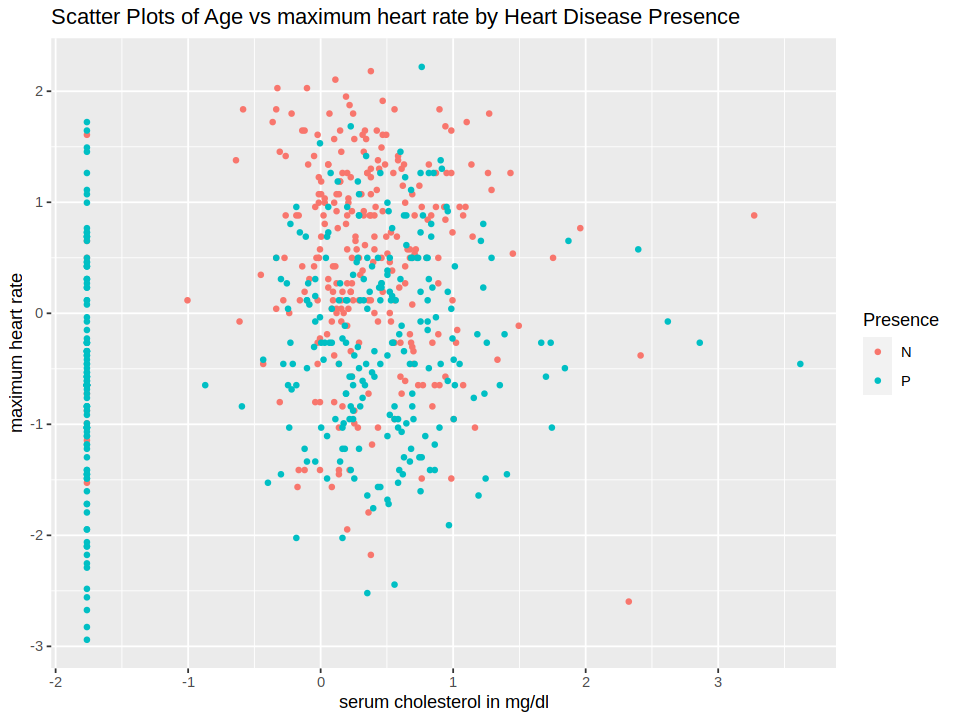

In [7]:
# Scatter plot of serum cholesterol vs. maximum heart rate (thalch) colored by presence of heart disease

ggplot(heart_disease_train_scaled, aes(x = chol, y = thalch, color = presence)) +
  geom_point(size = 1.2) +  # Adjust the size value as needed
  labs(title = "Scatter Plots of Age vs maximum heart rate by Heart Disease Presence",
       x = "serum cholesterol in mg/dl",
       y = "maximum heart rate",
       color = "Presence")

Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


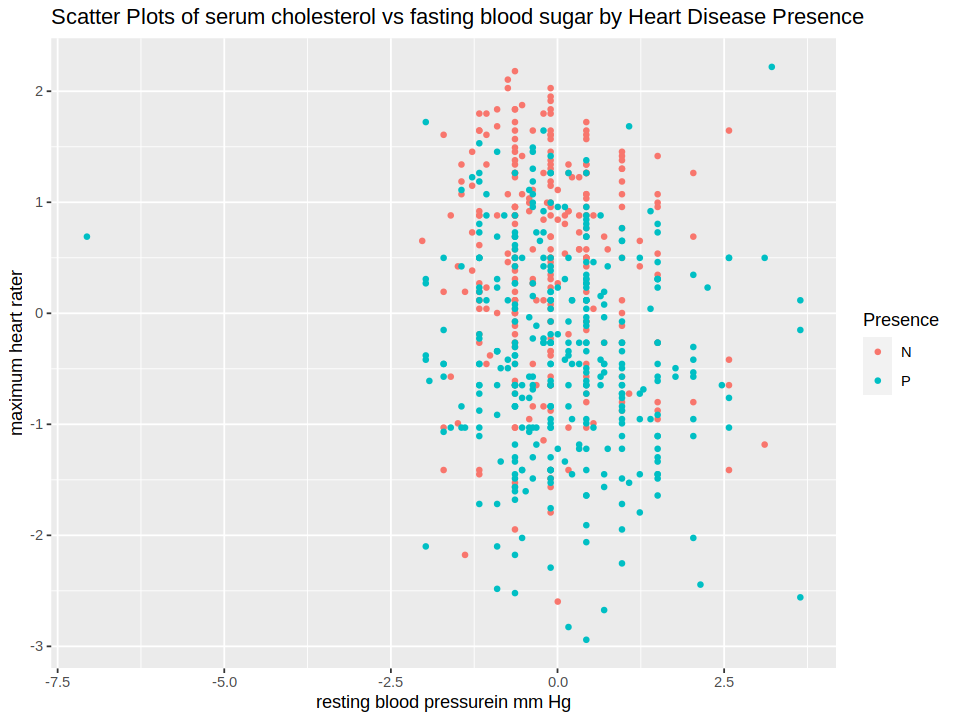

In [8]:
# Scatter plot of resting blood pressure vs. maximum heart rate colored by presence of heart disease

ggplot(heart_disease_train_scaled, aes(x = trestbps, y = thalch, color = presence)) +
  geom_point(size = 1.2) +  # Adjust the size value as needed
  labs(title = "Scatter Plots of serum cholesterol vs fasting blood sugar by Heart Disease Presence",
       x = "resting blood pressurein mm Hg",
       y = "maximum heart rater",
       color = "Presence")

## 3 - Method


First, we will import the dataset and perform data processing. This includes handling any missing values, addressing outliers, and standardizing our selected numerical predictors : maximum heart rate achieved (thalach), resting blood pressure (trestbps), serum cholesterol (chol), the number of major vessels colored by fluoroscopy (ca), and age (age). 

Next, we will split the data into training and testing sets to develop and train  our classification model. We will use the K-nearest neighbors algorithm, setting an appropriate value for 'K' through cross-validation.

After standardizing our predictors we will create multiple scatterplots or colour code bar-charts  for the presence (P) or absence (N) of heart disease. Through visualization, we aim to discern any patterns or correlations between the variables (such as Age and Serum Cholesterol), which will aid in understanding their individual impacts on heart disease diagnosis.

Subsequently, we will proceed to fit the K-nearest neighbors model to the training data. Using the testing data, we will assess the model's performance. These tools will enable us to comprehensively evaluate the classifier's efficacy in accurately predicting the presence of heart disease.


## 4 - Expected Outcomes and Significance

Our group expect to find whether K-nearest neighbors classification is an effective method for diagnosing heart disease based on our predictors. We also expect to evaluate the model's performance in terms of accuracy, sensitivity, and recall ratios.

The Impacts of the Project Findings:
If KNN proves to be effective, it could contribute to a quicker and more effective diagnosis of heart disease and help professionals make more informed treatment options. This can significantly reduce healthcare expenses—decreasing unnecessary procedures. 

Future Questions:
- Are our proposals considered variables the most informative for heart disease diagnosis, or are there other key features that should be considered?
- How does knn performance compare to other machine learning algorithms or traditional diagnostic methods in diagnosing heart disease?


